In [12]:
import matplotlib
matplotlib.use('Agg') # Force matplotlib to not use any Xwindows backend.

import math
import random
import sys
import glob
import csv
import numpy as np
import matplotlib.pyplot as ppt
%matplotlib inline
import caffe
import adex.core
import adex.data
import adex.googlenet

AE_BATCH_NAME = 'imagenet-ae-50'
MIN_AE_CONFIDENCE = 0.5
MAX_ORIGINAL_IMAGES = 100 # May be None

CAFFE_ROOT = '/home/chrisbot/Projects/caffe'
DATA_ROOT = '/media/sf_Masterarbeit/data/ILSVRC2012_img_train'
AE_ROOT = '/media/sf_Masterarbeit/data/ILSVRC2012_img_train_AE_50'
SAVE_PATH_PREFIX = '/media/sf_Masterarbeit/master-thesis/report/images/spectra/{0}-{1}'.format(AE_BATCH_NAME, MIN_AE_CONFIDENCE)

BATCH_SIZE = 1
net = adex.googlenet.load_model(CAFFE_ROOT, BATCH_SIZE)
transformer = adex.googlenet.build_transformer(net)

In [2]:
def get_ae_list(ae_root, min_ae_confidence):
    ae_list = []
    for csv_path in glob.glob(ae_root + '/*.csv'):
        with open(csv_path) as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                row[2], row[3] = float(row[2]), int(row[3])
                ae_path = ae_root + '/' + row[0].split('.')[0] + '/' + row[1] + '.npy'
                if row[2] >= min_ae_confidence:
                    ae_list.append(ae_path)
    return ae_list

ae_list = get_ae_list(AE_ROOT, MIN_AE_CONFIDENCE)
sys.stdout.write('Working with {0} AEs\n'.format(len(ae_list)))
sys.stdout.flush()

def get_original_list(data_root, max_original_images):
    original_list = []
    for cls_path in glob.glob(data_root + '/*'):
        for cls_member in glob.glob(cls_path + '/*'):
            original_list.append(cls_member)
    random.shuffle(original_list)
    if max_original_images is not None:
        original_list = original_list[:max_original_images]
    return(original_list)
    
original_list = get_original_list(DATA_ROOT, MAX_ORIGINAL_IMAGES)
sys.stdout.write('Working with {0} original images\n'.format(len(original_list)))
sys.stdout.flush()

Working with 287 AEs
Working with 100 original images


In [3]:
def original_loader(path):
    img = adex.googlenet.load_image(transformer, path)
    img = adex.data.grayvalue_image(img)
    img = img[...,:-1,:-1] # FIXME remove this
    img /= math.sqrt(np.sum(img**2))
    return img

def ae_loader(path):
    img = np.load(path)
    img = adex.data.grayvalue_image(img)
    img = img[...,:-1,:-1] # FIXME remove this
    img /= math.sqrt(np.sum(img**2))
    return img

def compute_spectrum(image_list, image_loader):
    spectrum = None
    
    for idx, path in enumerate(image_list):
        img = image_loader(path)

        if spectrum is None:
            spectrum = adex.data.get_spectrum(img)
        else:
            spectrum += adex.data.get_spectrum(img)
        
        # A bit of progress feedback every 1000 images
        if idx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()
    sys.stdout.write('\n')
    sys.stdout.flush()
    
    spectrum /= len(image_list)
    return spectrum

sys.stdout.write('Computing original spectrum')
original_spectrum = compute_spectrum(original_list, original_loader)
sys.stdout.flush()

sys.stdout.write('Computing AE spectrum')
ae_spectrum = compute_spectrum(ae_list, ae_loader)
sys.stdout.write('\ndone.')
sys.stdout.flush()

log_spectra_difference = np.log(original_spectrum) - np.log(ae_spectrum)

Computing original spectrum....................................................................................................
Computing AE spectrum...............................................................................................................................................................................................................................................................................................


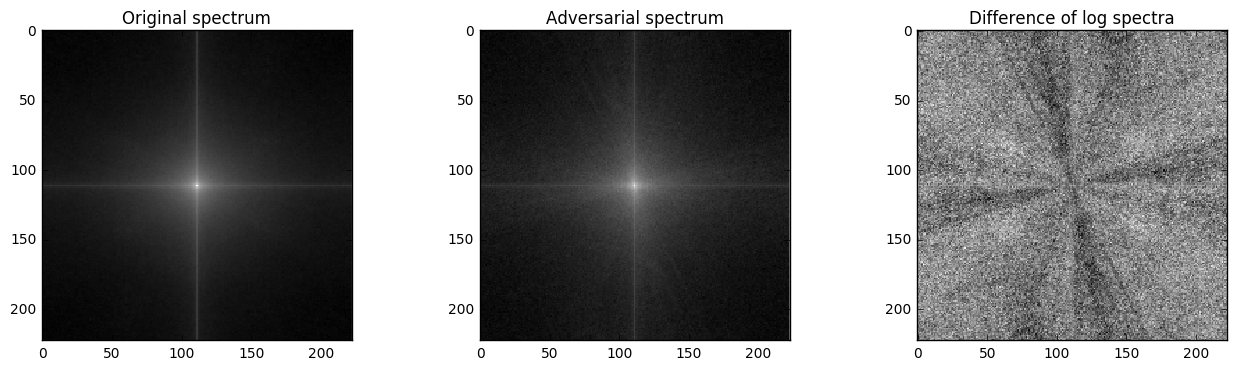

In [14]:
fig = ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
ppt.imshow(np.log(original_spectrum[0, 0]), cmap='gray', interpolation='none')
ppt.title('Original spectrum')

ax = ppt.subplot(1, 3, 2)
ppt.imshow(np.log(ae_spectrum[0, 0]), cmap='gray', interpolation='none')
ppt.title('Adversarial spectrum')

ax = ppt.subplot(1, 3, 3)
ppt.imshow(log_spectra_difference[0, 0], cmap='gray', interpolation='none')
ppt.title('Difference of log spectra')

fig.savefig(SAVE_PATH_PREFIX + 'spectra.png', bbox_inches='tight')

In [8]:
def activity_distribution(spectrum, range_bins, angle_bins):
    spectrum = spectrum.reshape(spectrum.shape[-2:])
    if spectrum.shape[0] % 2 == 0: # If side length is even
        center = np.asarray(spectrum.shape) / 2 - np.asarray([1,1])
        spectrum = spectrum[1:,1:] # cut off asymmetric parts, shape is now uneven
    else: # Side length is odd
        center = np.asarray(spectrum.shape) / 2

    # Record the summed values at every distance and angle to the origin, and the number of summed values
    distance_distribution = np.zeros(shape=(2, range_bins))
    angle_distribution = np.zeros(shape=(2, angle_bins))
    
    # Maxima, the bins scale linearly between 0 and these values
    max_distance = math.ceil(np.linalg.norm(center))
    max_angle = 2 * math.pi
    
    for index, value in np.ndenumerate(spectrum):
        # Compute distance to origin and the corresponding bin index
        distance = np.linalg.norm(np.asarray(index) - center)
        distance_index = (distance / max_distance) * range_bins
        distance_index = int(math.floor(distance_index))
        distance_distribution[:, distance_index] += (value, 1) # Record data in appropriate bin
        
        # Compute angle and the corresponding bin index
        angle = math.atan2(center[0] - index[0], index[1] - center[1])
        if angle < 0: # atan2 gives values from -pi to pi. Shift them to 0 to 2pi
            angle += 2 * math.pi
        angle_index = (angle / max_angle) * angle_bins # from 0 to angle_bins
        angle_index = int(math.floor(angle_index))
        
        if not (np.asarray(index) == center).all(): #ignore origin since it has no well-defined angle
            angle_distribution[:, angle_index] += (value, 1) # Record data in appropriate bin
    
    # Normalize with the number of summed values. Use 0 if there was no point at that distance.
    distance_distribution = np.where(distance_distribution[1] == 0, 0, distance_distribution[0] / distance_distribution[1])
    angle_distribution = angle_distribution[0] / (angle_distribution[1])
    
    return distance_distribution, angle_distribution

distance_bins = int(round(np.linalg.norm(original_spectrum.shape) / 2))
angle_bins = 8
print('Using {0} distance bins and {1} angle bins'.format(distance_bins, angle_bins))

original_distance_distribution, original_angle_distribution = activity_distribution(original_spectrum, distance_bins, angle_bins)
ae_distance_distribution, ae_angle_distribution = activity_distribution(ae_spectrum, distance_bins, angle_bins)
diff_distance_distribution, diff_angle_distribution = activity_distribution(log_spectra_difference, distance_bins, angle_bins)

Using 158 distance bins and 8 angle bins


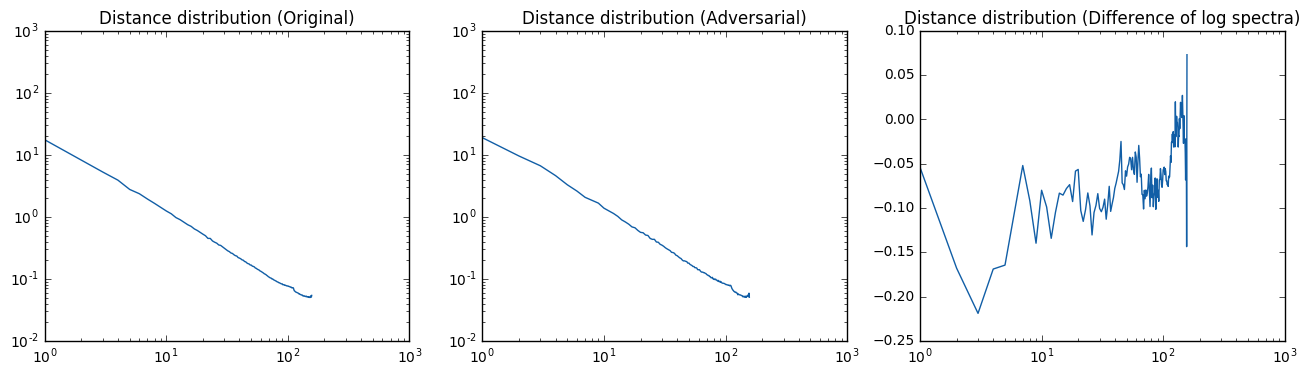

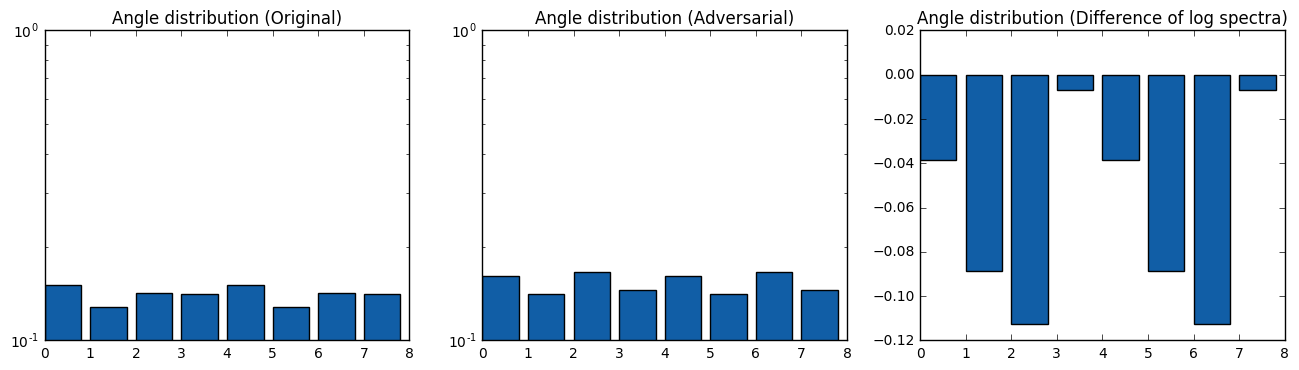

In [20]:
fig = ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(original_distance_distribution, color='#115EA6')
ppt.title('Distance distribution (Original)')

ax = ppt.subplot(1, 3, 2)
ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(ae_distance_distribution, color='#115EA6')
ppt.title('Distance distribution (Adversarial)')

ax = ppt.subplot(1, 3, 3)
ax.set_xscale('log')
#ax.set_yscale('log')
ppt.plot(diff_distance_distribution, color='#115EA6')
ppt.title('Distance distribution (Difference of log spectra)')

fig.savefig(SAVE_PATH_PREFIX + '-spectra-distance-{0}-bins.png'.format(distance_bins), bbox_inches='tight')



fig = ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
#ax.set_xscale('log')
ax.set_yscale('log')
#ppt.plot(original_angle_distribution)
ppt.bar(np.arange(angle_bins), original_angle_distribution, color='#115EA6')
ppt.title('Angle distribution (Original)')

ax = ppt.subplot(1, 3, 2)
#ax.set_xscale('log')
ax.set_yscale('log')
#ppt.plot(adversarial_angle_distribution)
ppt.bar(np.arange(angle_bins), ae_angle_distribution, color='#115EA6')
ppt.title('Angle distribution (Adversarial)')

ax = ppt.subplot(1, 3, 3)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ppt.plot(diff_angle_distribution)
ppt.bar(np.arange(angle_bins), diff_angle_distribution, color='#115EA6')
ppt.title('Angle distribution (Difference of log spectra)')

fig.savefig(SAVE_PATH_PREFIX + '-spectra-angle-{0}-bins.png'.format(angle_bins), bbox_inches='tight')